In [283]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sympy
from operator import itemgetter
from sympy.physics.quantum.cg import CG

In [284]:
%run Q_and_M_database.ipynb

Number of misbehaved entries:  1
Total number of entries analyzed:  1208
Total number of entries uncleaned:  1208
Total number of entries inserted:  1175
Long lived magnetic dipole moments loaded as M_LL
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, mu, un].
Number of misbehaved entries:  65
Total number of entries analyzed:  1356
Total number of entries uncleaned:  1356
Total number of entries inserted:  1164
Short lived magnetic dipole moments loaded as M_SL
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, q, un, E, jp].
Magnetic dipole moments loaded as M
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, mu, un].
Total number of entries uncleaned:  2564
Total number of entries inserted:  2339
Number of misbehaved entries:  164
Total number of entries analyzed:  1468
Total number of entr

## Hamiltonian and H.O. radial wavefunctions

In [3]:
# Constants

hbar = 6.582119569*10**(-22)           # MeV*s
c = 2.99792458*10**(8)*10**(15)        # fm/s
m_p = 938.27/c**2                      # MeV*s²/fm²
m_n = 939.57/c**2                      # MeV*s²/fm²

def hbaromega(A):                          # Parameters: A mass number of nucleus
    return 45*A**(-1/3) - 25*A**(-2/3) 

def b(m,A):                                # Parameters: m mass of nucleon, A mass number of nucleus
    return hbar/np.sqrt(m*hbaromega(A))

In [4]:
# Harmonic oscillator radial wavefunction

def psiHO(r, n, l, m, A):                 # Parameters: r coordinate, n radial quantum number
                                          #             l orbital angular momentum,
                                          #             m mass of nucleon, A mass number of nucleus
    bv = b(m,A)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv**3*scp.special.gamma(n+l+3/2)))
    return norm*(r/bv)**l*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)

In [5]:
# Harmonic oscillator total wavefunction

def PSI_HO(r, th, ph, n, l, j, proj, m, A):    # Parameters: r coordinate, n radial quantum number, th theta coordinate, ph azimutal coordinate
                                               #             l orbital angular momentum,
                                               #             j total angular momentum,
                                               #             proj is the projection of the total angular momentum
                                               #             m mass of nucleon, A mass number of nucleus
    bv = b(m,A)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv**3*scp.special.gamma(n+l+3/2)))
    radial_wf = norm*(r/bv)**l*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)

    ang_spin_wf = np.array([0+0j,0+0j])
    for ml in range(-l,l+1):
        for ms in np.arange(-1/2,1/2+1,1):
            
            if ms == 1/2:
                ang_spin_wf += float(CG(l, ml, 1/2, ms, j, proj).doit())*scp.special.sph_harm(ml, l, th, ph)*np.array([1+0j, 0+0j])
            
            if ms == -1/2:
                ang_spin_wf += float(CG(l, ml, 1/2, ms, j, proj).doit())*scp.special.sph_harm(ml, l, th, ph)*np.array([0+0j, 1+0j])

    return radial_wf*ang_spin_wf

In [6]:
def wavefunction_evaluator(n, l, j, proj, m, A, x_interval, y_interval, z_interval, density):
    
       # Parameters:  n radial quantum number                       
       #             l orbital angular momentum,
       #             j total angular momentum,
       #             proj is the projection of the total angular momentum
       #             m mass of nucleon, A mass number of nucleus
       #             x_interval, y_interval and z_interval are the spatial intervals for the calculation of the w.f. They must be lists

    wf = []
    
    X = np.linspace(x_interval[0], x_interval[1], density)
    Y = np.linspace(y_interval[0], y_interval[1], density)
    Z = np.linspace(z_interval[0], z_interval[1], density)
    
    #probsum = 0
    
    for x in X:
        for y in Y:
            for z in Z:
                    
                r  = np.sqrt(x**2 + y**2 + z**2)
                th = np.arccos(z/r)
                ph = np.arctan(y/x) 
                
                ampl = PSI_HO(r, th, ph, n, l, j, proj, m, A)
                prob = abs(np.dot(ampl, np.conjugate(ampl)))
                
                wf.append([x,y,z,prob])
                
                #probsum += prob                
    return wf

In [7]:
# Function to compute <r^2>

def Integrand(r,n,l,m,N,Z,part):          # Parameters: r coordinate, n1, n2 radial quantum numbers, 
                                          #             l orbital angular momentum, N number of neutrons,
                                          #             Z number of protons, part = 0 for proton and 
                                          #             1 for neutron
    f1 = psiHO(r, n, l, m, Z+N)
    
    return r**4*f1*f1

def MSR(n,l,m,N,Z,part):
    
    return scp.integrate.quad(Integrand, 0, 200, args=(n,l,m,N,Z,part))[0]   # Integral up to 200fm

In [8]:
def Q_sp(n, l, m, N, Z, part):
    
    j1 = l+1/2
    j2 = l-1/2
    msr = MSR(n,l,m,N,Z,part)
    
    if l == 0:
        return [[2*j1, -1*part*(2*j1-1)/(2*j1+2)*msr]]
    else:
        return [[2*j1, -1*(1-part)*(2*j1-1)/(2*j1+2)*msr], [2*j2, -1*(1-part)*(2*j2-1)/(2*j2+2)*msr]]

In [9]:
def M_sp(j_max):
    
    gl_n = 0
    gl_p = 1
    gs_n = -3.826 
    gs_p = 5.586
    
    mump = []
    mupp = []
    mumn = []
    mupn = []
    
    jj = []
    
    for j in np.arange(0.5, j_max+1, 1):
        
        jj.append(j)
        mump.append(gl_p*j-(gs_p-gl_p)*(j)/(2*j+2))
        mupp.append(gl_p*j + (gs_p-gl_p)/2)
        
        mumn.append(gl_n*j-(gs_n-gl_n)*(j)/(2*j+2))
        mupn.append(gl_n*j + (gs_n-gl_n)/2)
        
    return jj, mump, mupp, mumn, mupn

# Wave function probability distribution 

In [9]:
wf2 = np.array(wavefunction_evaluator(1, 1, 1/2, 1/2, m_p, 90,[-5.5,5.5], [-5.5,5.5], [-5.5,5.5], 30))

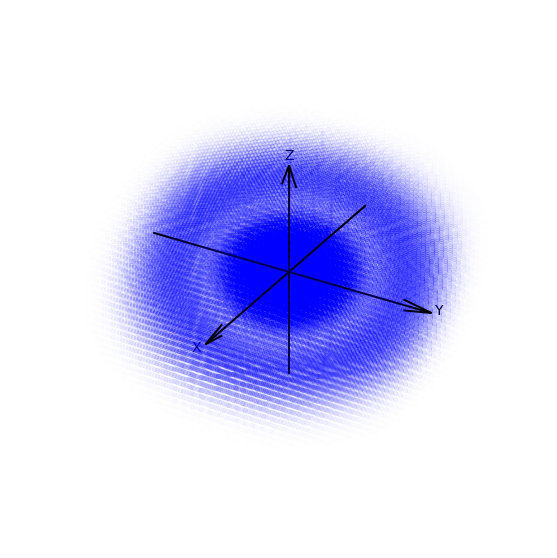

In [15]:
#%matplotlib notebook

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")

#maximum_prob = max(wf[:,3])
#maximum_prob1 = max(wf1[:,3])
maximum_prob2 = max(wf2[:,3])

for i in range(len(wf2)):
    #ax.scatter(wf[i][0],wf[i][1],wf[i][2], alpha=wf[i][3]/maximum_prob, color = "blue")
    #ax.scatter(wf1[i][0],wf1[i][1],wf1[i][2], alpha=wf1[i][3]/maximum_prob1, color = "red")
    ax.scatter(wf2[i][0],wf2[i][1],wf2[i][2], alpha=wf2[i][3]/maximum_prob2, color = "blue")

# ax.set_xlabel('X [fm]')
# ax.set_ylabel('Y [fm]')
# ax.set_zlabel('Z [fm]')

# Remove panes
ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)

# Remove grid
ax.grid(False)

# Hide axes lines
ax.w_xaxis.line.set_color((0, 0, 0, 0))
ax.w_yaxis.line.set_color((0, 0, 0, 0))
ax.w_zaxis.line.set_color((0, 0, 0, 0))

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

zmin, zmax = ax.get_zlim()
ax.quiver(0, 0, zmin,        # start point (0,0,zmin)
          0, 0, zmax-zmin,   # direction only along z
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)
ax.text(0, 0, zmax*1.05, "Z", color="k", fontsize=14, ha="center")



xmin, xmax = ax.get_xlim()
ax.quiver(xmin, 0, 0,        # start point (0,0,zmin)
          xmax-xmin, 0, 0,   # direction only along z
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)
ax.text(xmax*1.05, 0, 0, "Y", color="k", fontsize=14, ha="center")



ymin, ymax = ax.get_ylim()
ax.quiver(0, -ymin, 0,
          0, -ymax+ymin, 0, 
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)
ax.text(0, -ymax*1.1, 0, "X", color="k", fontsize=14, ha="center")


# Z0 = np.zeros_like(X)
# ax.plot_surface(X, Y, Z0, color="lightgray", alpha=0.3, zorder=0)

plt.savefig("1p0.5.png", facecolor='white', bbox_inches='tight')
plt.show()

In [17]:
wf1 = np.array(wavefunction_evaluator(2, 1, 3/2, 3/2, m_p, 90,[-5.5,5.5], [-5.5,5.5], [-5.5,5.5], 30))
#wf2 = np.array(wavefunction_evaluator(0, 2, 5/2, 5/2, m_p, 90,[-5.5,5.5], [-5.5,5.5], [-5.5,5.5], 30))

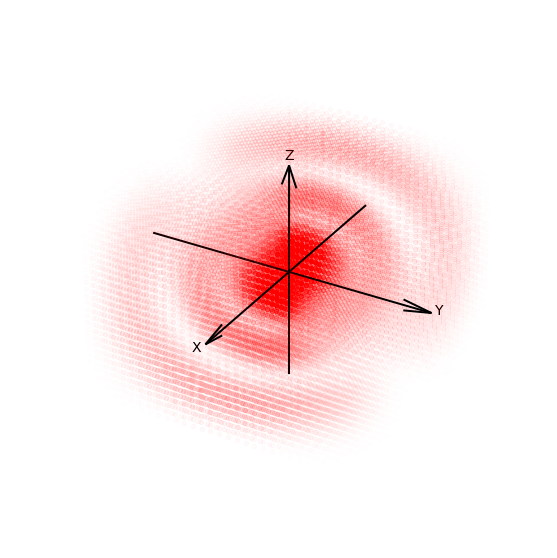

In [18]:
#%matplotlib notebook

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")

#maximum_prob = max(wf[:,3])
maximum_prob1 = max(wf1[:,3])
#maximum_prob2 = max(wf2[:,3])

for i in range(len(wf1)):
    #ax.scatter(wf[i][0],wf[i][1],wf[i][2], alpha=wf[i][3]/maximum_prob, color = "blue")
    ax.scatter(wf1[i][0],wf1[i][1],wf1[i][2], alpha=wf1[i][3]/maximum_prob1, color = "red")
    #ax.scatter(wf2[i][0],wf2[i][1],wf2[i][2], alpha=wf2[i][3]/maximum_prob2, color = "orange")

# ax.set_xlabel('X [fm]')
# ax.set_ylabel('Y [fm]')
# ax.set_zlabel('Z [fm]')

# Remove panes
ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)

# Remove grid
ax.grid(False)

# Hide axes lines
ax.w_xaxis.line.set_color((0, 0, 0, 0))
ax.w_yaxis.line.set_color((0, 0, 0, 0))
ax.w_zaxis.line.set_color((0, 0, 0, 0))

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

zmin, zmax = ax.get_zlim()
ax.quiver(0, 0, zmin,        # start point (0,0,zmin)
          0, 0, zmax-zmin,   # direction only along z
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)

ax.text(0, 0, zmax*1.05, "Z", color="k", fontsize=14, ha="center")


xmin, xmax = ax.get_xlim()
ax.quiver(xmin, 0, 0,        # start point (0,0,zmin)
          xmax-xmin, 0, 0,   # direction only along z
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)
ax.text(xmax*1.05, 0, 0, "Y", color="k", fontsize=14, ha="center")



ymin, ymax = ax.get_ylim()
ax.quiver(0, -ymin, 0,
          0, -ymax+ymin, 0, 
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)
ax.text(0, -ymax*1.1, 0, "X", color="k", fontsize=14, ha="center")



# Z0 = np.zeros_like(X)
# ax.plot_surface(X, Y, Z0, color="lightgray", alpha=0.3, zorder=0)

plt.savefig("2p1.5.png", facecolor='white', bbox_inches='tight')
plt.show()

In [19]:
wf1 = np.array(wavefunction_evaluator(0, 2, 5/2, 5/2, m_p, 90,[-5.5,5.5], [-5.5,5.5], [-5.5,5.5], 30))
#wf2 = np.array(wavefunction_evaluator(0, 2, 5/2, 5/2, m_p, 90,[-5.5,5.5], [-5.5,5.5], [-5.5,5.5], 30))

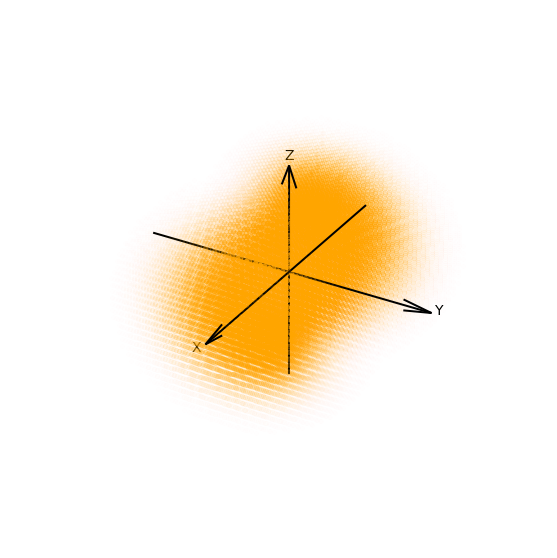

In [20]:
#%matplotlib notebook

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")

#maximum_prob = max(wf[:,3])
maximum_prob1 = max(wf1[:,3])
#maximum_prob2 = max(wf2[:,3])

for i in range(len(wf1)):
    #ax.scatter(wf[i][0],wf[i][1],wf[i][2], alpha=wf[i][3]/maximum_prob, color = "blue")
    ax.scatter(wf1[i][0],wf1[i][1],wf1[i][2], alpha=wf1[i][3]/maximum_prob1, color = "orange")
    #ax.scatter(wf2[i][0],wf2[i][1],wf2[i][2], alpha=wf2[i][3]/maximum_prob2, color = "orange")

# ax.set_xlabel('X [fm]')
# ax.set_ylabel('Y [fm]')
# ax.set_zlabel('Z [fm]')

# Remove panes
ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)

# Remove grid
ax.grid(False)

# Hide axes lines
ax.w_xaxis.line.set_color((0, 0, 0, 0))
ax.w_yaxis.line.set_color((0, 0, 0, 0))
ax.w_zaxis.line.set_color((0, 0, 0, 0))

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

zmin, zmax = ax.get_zlim()
ax.quiver(0, 0, zmin,        # start point (0,0,zmin)
          0, 0, zmax-zmin,   # direction only along z
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)

ax.text(0, 0, zmax*1.05, "Z", color="k", fontsize=14, ha="center")


xmin, xmax = ax.get_xlim()
ax.quiver(xmin, 0, 0,        # start point (0,0,zmin)
          xmax-xmin, 0, 0,   # direction only along z
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)
ax.text(xmax*1.05, 0, 0, "Y", color="k", fontsize=14, ha="center")



ymin, ymax = ax.get_ylim()
ax.quiver(0, -ymin, 0,
          0, -ymax+ymin, 0, 
          arrow_length_ratio=0.1,
          color="k", lw=2, linewidths=2)
ax.text(0, -ymax*1.1, 0, "X", color="k", fontsize=14, ha="center")



# Z0 = np.zeros_like(X)
# ax.plot_surface(X, Y, Z0, color="lightgray", alpha=0.3, zorder=0)

plt.savefig("0d2.5.png", facecolor='white', bbox_inches='tight')
plt.show()

# Quadrupole moments

In [10]:
Qs = np.array(Q_sp(0, 0, m_p, 2, 2, 0))  # 4He
Qp = np.array(Q_sp(0, 1, m_p, 5, 5, 0))  # 10B
Qsd = np.array(Q_sp(0, 2, m_p, 10, 10, 0) + Q_sp(2, 0, m_p, 10, 10, 0))   # 20Ne
Qpf = np.array(Q_sp(1, 1, m_p, 26, 24, 0) + Q_sp(0, 3, m_p, 26, 24, 0))   # 50Cr
Qsdg = np.array(Q_sp(2, 0, m_p, 90, 64, 0) + Q_sp(1, 2, m_p, 90, 64, 0) + Q_sp(0, 4, m_p, 90, 64, 0))  # 154Ga
Qpfh = np.array(Q_sp(2, 1, m_p, 134, 90, 0) + Q_sp(1, 3, m_p, 134, 90, 0) + Q_sp(0, 5, m_p, 134, 90, 0))  # 224Th

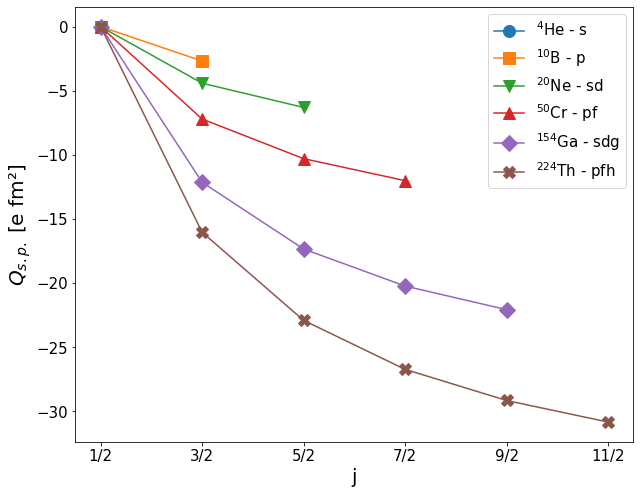

In [11]:
plt.figure(figsize=((10,8)))

Qs[:,0], Qs[:,1] = zip(*sorted(zip(Qs[:,0], Qs[:,1])))
plt.plot(Qs[:,0]/2, Qs[:,1],"o-",zorder=20, color="C0", label = r"$^{4}$He - s", markersize=12)
   
Qp[:,0], Qp[:,1] = zip(*sorted(zip(Qp[:,0], Qp[:,1])))
plt.plot(Qp[:,0]/2, Qp[:,1],"s-",zorder=20, color="C1", label = r"$^{10}$B - p", markersize=12)

Qsd[:,0], Qsd[:,1] = zip(*sorted(zip(Qsd[:,0], Qsd[:,1])))
plt.plot(Qsd[:,0]/2, Qsd[:,1],"v-",zorder=20, color="C2", label = r"$^{20}$Ne - sd", markersize=12)
    
Qpf[:,0], Qpf[:,1] = zip(*sorted(zip(Qpf[:,0], Qpf[:,1])))
plt.plot(Qpf[:,0]/2, Qpf[:,1],"^-",zorder=20, color="C3", label = r"$^{50}$Cr - pf", markersize=12)   
    
Qsdg[:,0], Qsdg[:,1] = zip(*sorted(zip(Qsdg[:,0], Qsdg[:,1])))
plt.plot(Qsdg[:,0]/2, Qsdg[:,1],"D-",zorder=20, color="C4", label = r"$^{154}$Ga - sdg", markersize=12)

Qpfh[:,0], Qpfh[:,1] = zip(*sorted(zip(Qpfh[:,0], Qpfh[:,1])))
plt.plot(Qpfh[:,0]/2, Qpfh[:,1],"X-",zorder=20, color="C5", label = r"$^{224}$Th - pfh", markersize=12)
    

def Q_empirical(j,A):
    return -(2*j-1)/(2*j+2)*3/5*A**(2/3)*1.2**2

#plt.plot(np.array([0.5,1.5,2.5,3.5,4.5]), np.array([Q_empirical(0.5,4), Q_empirical(1.5,10), Q_empirical(2.5,20), Q_empirical(3.5,50), Q_empirical(4.5,154)]), "o-",zorder=1, color="red")

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5],["1/2","3/2","5/2","7/2","9/2","11/2"], fontsize=15)
plt.yticks( fontsize=15)

#plt.plot([0.5,1.5,2.5,3.5,4.5,5.5],[Q_empirical(0.5,224),Q_empirical(1.5,224),Q_empirical(2.5,224),Q_empirical(3.5,224),Q_empirical(4.5,224),Q_empirical(5.5,224)], "o-",c="k")
#plt.plot([0.5,1.5,2.5,3.5,4.5],[Q_empirical(0.5,154),Q_empirical(1.5,154),Q_empirical(2.5,154),Q_empirical(3.5,154),Q_empirical(4.5,154)], "o-",c="k")

plt.xlabel("j", fontsize=20)
plt.ylabel(r"$Q_{s.p.}$ [e fm²]", fontsize=20)
plt.legend(fontsize=15)


plt.savefig("Qsp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

### All this is odd-mass since we want to see the s.p. influence. Dominance of the <r²> term and its approxiamtion as $\frac{3}{5}r_0^2A^{2/3}$

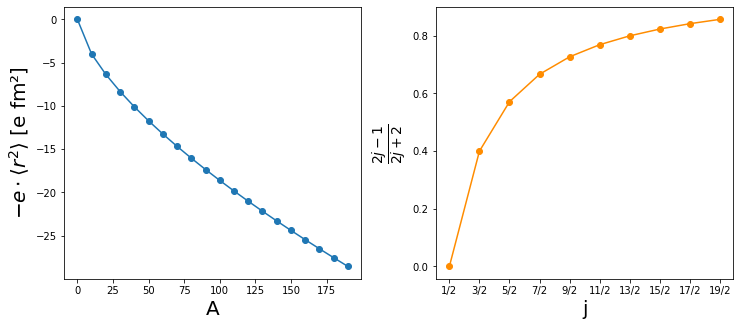

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Crear dos subgráficos en una fila

x1 = np.arange(0, 200, 10)
y1 = -1 * 3/5 * 1.2**2 * x1**(2/3)
axes[0].plot(x1, y1, "o-")
axes[0].set_xlabel("A", fontsize=20)
axes[0].set_ylabel(r"$-e\cdot\langle r^2 \rangle$ [e fm²]", fontsize=20)

x2 = np.arange(0.5, 10.5, 1)
y2 = (2 * x2 - 1) / (2 * x2 + 2)
axes[1].plot(x2, y2, "o-", color="darkorange")
axes[1].set_xlabel("j", fontsize=20)
axes[1].set_ylabel(r"$\frac{2j-1}{2j+2}$", fontsize=20)
axes[1].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2","15/2","17/2","19/2"])

plt.subplots_adjust(wspace=0.25)
plt.savefig("RvsJsp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()


In [13]:
Q_odd_A = Q.copy()
Q_odd_A["A"] = pd.to_numeric(Q_odd_A["A"], downcast='integer', errors='coerce')
Q_odd_A = Q_odd_A[Q_odd_A["A"]%2==1]
dataq = extract_q(Q_odd_A, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

None of the available formats:


Z                                               48
Sym                                             Cd
A                                              109
E(level)                                       463
T_1/2                                       10.9µs
I                                            11/2-
Q(b)                                    [-0.92(9)]
Ref._Std.                                         
Method                                  systematic
NSR_Keynumber                                  not
Journal_reference    measured1978Sp09HFI4229(1978)
Name: 387, dtype: object

None of the available formats:


Z                                                    85
Sym                                                  At
A                                                   211
E(level)                                           1417
T_1/2                                            35.1ns
I                                                 21/2-
Q(b)                                     [(-)0.524(10)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1995Ba66NPA591104(1996)
Name: 1073, dtype: object

None of the available formats:


Z                                                 87
Sym                                               Fr
A                                                213
E(level)                                        2538
T_1/2                                          238ns
I                                              29/2+
Q(b)                                      [-0.70(7)]
Ref._Std.                                           
Method                                    calculated
NSR_Keynumber                                    not
Journal_reference    measured1990By03NPA516145(1990)
Name: 1112, dtype: object

None of the available formats:


Z                                                   91
Sym                                                 Pa
A                                                  231
E(level)                                             0
T_1/2                                         3.3x104y
I                                                 3/2-
Q(b)                                        [-1.72(5)]
Ref._Std.                                             
Method                                            from
NSR_Keynumber                                    B(E2)
Journal_reference    notmeasured1978Fr28PLA69225(1975)
Name: 1135, dtype: object

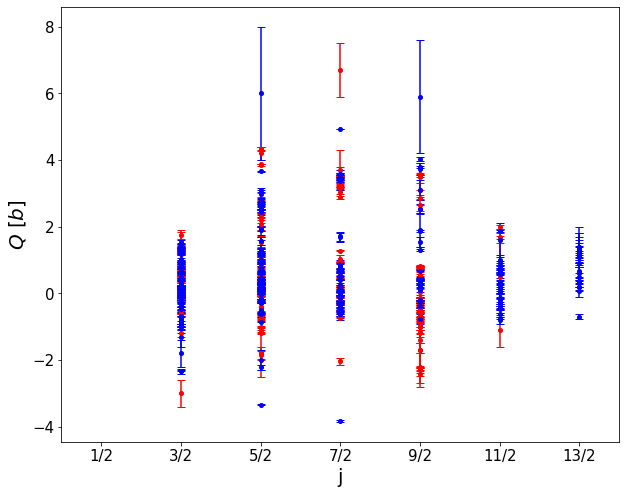

In [14]:
plt.figure(figsize=((10,8)))

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_mu_Z = [] 
dataq_lower_Z = [] 
dataq_upper_Z = [] 
#dataq_E_Z = [] 
dataq_jp_Z = []

# Odd N
#dataq_Z_N = [] 
#dataq_A_N = [] 
dataq_mu_N = [] 
dataq_lower_N = [] 
dataq_upper_N = [] 
#dataq_E_N = [] 
dataq_jp_N = []

for i in range(len(dataq[0])):
    
    if (dataq[0][i]%2==1):
        # Append in the odd Z array
        if "(" in dataq[5][i]:
            jjpp = dataq[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            
            if "/" not in dataq[5][i]:
                continue
            jjpp = float(dataq[5][i].split("/")[0])/2
            
        dataq_mu_Z.append(dataq[2][i])
        dataq_lower_Z.append(lower_error[i])
        dataq_upper_Z.append(upper_error[i])
        dataq_jp_Z.append(jjpp)
    
    if (dataq[0][i]%2==0):
        # Append in the odd N array
        if "(" in dataq[5][i]:
            jjpp = dataq[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            if "/" not in dataq[5][i]:
                continue
            jjpp = float(dataq[5][i].split("/")[0])/2
            
        dataq_mu_N.append(dataq[2][i])
        dataq_lower_N.append(lower_error[i])
        dataq_upper_N.append(upper_error[i])
        dataq_jp_N.append(jjpp)
    
asymmetric_error_Z = np.array(list(zip(dataq_lower_Z, dataq_upper_Z))).T
plt.errorbar(dataq_jp_Z, dataq_mu_Z, yerr=asymmetric_error_Z, fmt='o', color = "red" ,markersize=4, capsize=4) 
asymmetric_error_N = np.array(list(zip(dataq_lower_N, dataq_upper_N))).T
plt.errorbar(dataq_jp_N, dataq_mu_N, yerr=asymmetric_error_N, fmt='o', color = "blue", markersize=4, capsize=4) 


#plt.yticks(np.arange(int(min(dataq[2]))-1, int(max(dataq[2]))+2, 1), size=20)
plt.xlim(0,7)
#plt.ylim(-2.5,10.5)

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("j", size=20)
plt.ylabel(r"$Q$ [$b$]", size=20)
plt.show()

# Magnetic dipole moments

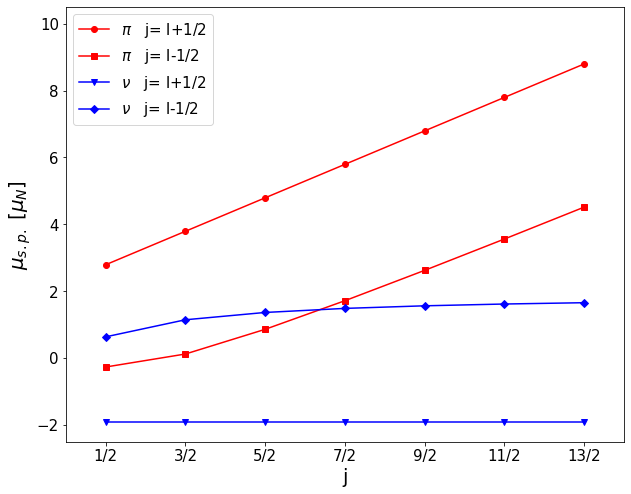

In [15]:
jj, mump, mupp, mumn, mupn = M_sp(13/2)

plt.figure(figsize=((10,8)))

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=15)
plt.yticks(fontsize=15)

plt.plot(jj, mupp ,"o-", c="red", label=r"$\pi$   j= l+1/2")
plt.plot(jj, mump ,"s-", c="red", label=r"$\pi$   j= l-1/2")

plt.plot(jj, mupn ,"v-", c="blue", label=r"$\nu$   j= l+1/2")
plt.plot(jj, mumn ,"D-", c="blue", label=r"$\nu$   j= l-1/2")

plt.xlabel("j", fontsize=20)
plt.ylabel(r"$\mu_{s.p.}$ [$\mu_N$]", fontsize=20)
plt.legend(fontsize=15)

plt.xlim(0,7)
plt.ylim(-2.5,10.5)

plt.savefig("Msp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [16]:
M_LL_Odd_A = M_LL.copy()
M_LL_Odd_A["A"] = pd.to_numeric(M_LL_Odd_A["A"], downcast='integer', errors='coerce')
M_LL_Odd_A = M_LL_Odd_A[M_LL_Odd_A["A"]%2==1]
datamll = extract_mu(M_LL_Odd_A, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

Data with none of the available formats:


Z                                                  85
Sym                                                At
A                                                 211
Ex                                                  0
T1/2                                            7.21h
Jπ                                               9/2-
m(nm)                Ref.estimated+4.14(not_measured)
Method                                       2018Cu02
NSR_Keynumber                                      PR
Journal_Reference                     C97054327(2018)
Name: 1099, dtype: object

In [17]:
M_SL_Odd_A = M_SL.copy()
M_SL_Odd_A["A"] = pd.to_numeric(M_SL_Odd_A["A"], downcast='integer', errors='coerce')
M_SL_Odd_A = M_SL_Odd_A[M_SL_Odd_A["A"]%2==1]
datamsl = extract_mu(M_SL_Odd_A)#, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

Data with none of the available formats:


Z                                   49
Sym                                 In
A                                  117
Ex                                 589
T1/2                            0.19ns
Jπ                                3/2-
m(nm)                            >0.84
Method                           IPAC,
NSR_Keynumber                        R
Journal_Reference    1986Bo36/1985Al05
Name: 445, dtype: object

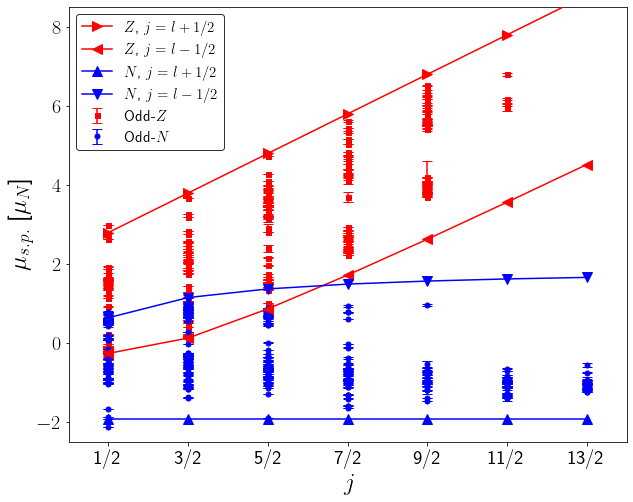

In [18]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(datamll[3])):
    try: 
        if len(datamll[3][i]) == 2:
            lower_error.append(datamll[3][i][1])
            upper_error.append(datamll[3][i][0])
    except: 
        lower_error.append(datamll[3][i])
        upper_error.append(datamll[3][i])
# =================================================================================        

# Odd Z
#datamll_Z_Z = [] 
#datamll_A_Z = [] 
datamll_mu_Z = [] 
datamll_lower_Z = [] 
datamll_upper_Z = [] 
#datamll_E_Z = [] 
datamll_jp_Z = []

# Odd N
#datamll_Z_N = [] 
#datamll_A_N = [] 
datamll_mu_N = [] 
datamll_lower_N = [] 
datamll_upper_N = [] 
#datamll_E_N = [] 
datamll_jp_N = []

for i in range(len(datamll[0])):
    
    if (datamll[0][i]%2==1):
        # Append in the odd Z array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            
        datamll_mu_Z.append(datamll[2][i])
        datamll_lower_Z.append(lower_error[i])
        datamll_upper_Z.append(upper_error[i])
        datamll_jp_Z.append(jjpp)
    
    if (datamll[0][i]%2==0):
        # Append in the odd N array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            
        datamll_mu_N.append(datamll[2][i])
        datamll_lower_N.append(lower_error[i])
        datamll_upper_N.append(upper_error[i])
        datamll_jp_N.append(jjpp)
    
asymmetric_error_Z = np.array(list(zip(datamll_lower_Z, datamll_upper_Z))).T
plt.errorbar(datamll_jp_Z, datamll_mu_Z, yerr=asymmetric_error_Z, fmt='s', color = "red" ,markersize=5, capsize=5, label=r"Odd-$Z$") 
asymmetric_error_N = np.array(list(zip(datamll_lower_N, datamll_upper_N))).T
plt.errorbar(datamll_jp_N, datamll_mu_N, yerr=asymmetric_error_N, fmt='o', color = "blue", markersize=5, capsize=5, label=r"Odd-$N$") 

#plt.yticks(np.arange(int(min(datamll[2]))-1, int(max(datamll[2]))+2, 1), size=20)
plt.xlim(0,7)
plt.ylim(-2.5,8.5)

plt.xlabel("Z", size=30)
plt.ylabel(r"$\mu$ [$\mu_N$]", size=30)

#####################################################################################################
# Schmidt lines
#####################################################################################################

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=20)
plt.yticks(fontsize=20)

plt.plot(jj, mupp ,">-", c="red", label=r"$Z$,   $j = l+1/2$", markersize=10, zorder=30)
plt.plot(jj, mump ,"<-", c="red", label=r"$Z$,   $j = l-1/2$", markersize=10, zorder=30)

plt.plot(jj, mupn ,"^-", c="blue", label=r"$N$,   $j = l+1/2$", markersize=10, zorder=30)
plt.plot(jj, mumn ,"v-", c="blue", label=r"$N$,   $j = l-1/2$", markersize=10, zorder=30)

plt.xlabel("$j$", fontsize=25)
plt.ylabel(r"$\mu_{s.p.}$ [$\mu_N$]", fontsize=25)

plt.legend(fontsize=15, edgecolor="black")#, markerscale=2)


plt.savefig("Msp+Exp_ll.svg", dpi=300, facecolor='white', bbox_inches='tight')
#plt.savefig("MExp.png", dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

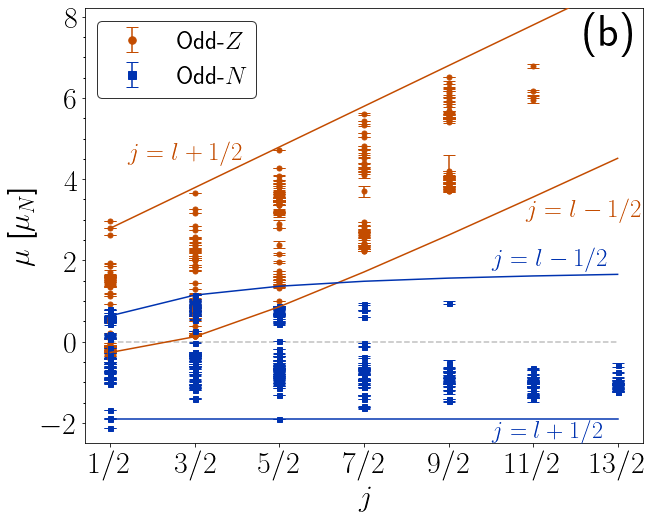

In [19]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(datamll[3])):
    try: 
        if len(datamll[3][i]) == 2:
            lower_error.append(datamll[3][i][1])
            upper_error.append(datamll[3][i][0])
    except: 
        lower_error.append(datamll[3][i])
        upper_error.append(datamll[3][i])
# =================================================================================        

# Odd Z
#datamll_Z_Z = [] 
#datamll_A_Z = [] 
datamll_mu_Z = [] 
datamll_lower_Z = [] 
datamll_upper_Z = [] 
#datamll_E_Z = [] 
datamll_jp_Z = []

# Odd N
#datamll_Z_N = [] 
#datamll_A_N = [] 
datamll_mu_N = [] 
datamll_lower_N = [] 
datamll_upper_N = [] 
#datamll_E_N = [] 
datamll_jp_N = []

for i in range(len(datamll[0])):
        
    if (datamll[0][i]%2==1 and datamll[1][i]%2==1):
        # Append in the odd Z array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            
        datamll_mu_Z.append(datamll[2][i])
        datamll_lower_Z.append(lower_error[i])
        datamll_upper_Z.append(upper_error[i])
        datamll_jp_Z.append(jjpp)
    
    if (datamll[0][i]%2==0 and datamll[1][i]%2==1):
        # Append in the odd N array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            

            
        datamll_mu_N.append(datamll[2][i])
        datamll_lower_N.append(lower_error[i])
        datamll_upper_N.append(upper_error[i])
        datamll_jp_N.append(jjpp)
        
    # Odd Odd
    if (datamll[0][i]%2==1 and datamll[1][i]%2==0):
        print(datamll[0][i], datamll[1][i], datamll[2][i], datamll[3][i])
        
    
asymmetric_error_Z = np.array(list(zip(datamll_lower_Z, datamll_upper_Z))).T
plt.errorbar(datamll_jp_Z, datamll_mu_Z, yerr=asymmetric_error_Z, fmt='o', color = "#c34c00" ,markersize=5, capsize=6, label=r"Odd-$Z$") 
asymmetric_error_N = np.array(list(zip(datamll_lower_N, datamll_upper_N))).T
plt.errorbar(datamll_jp_N, datamll_mu_N, yerr=asymmetric_error_N, fmt='s', color = "#0033b0", markersize=5, capsize=6, label=r"Odd-$N$") 



#plt.yticks(np.arange(int(min(datamll[2]))-1, int(max(datamll[2]))+2, 1), size=20)
plt.xlim(0.2,6.8)
plt.ylim(-2.5,8.2)

plt.xlabel("Z", size=30)
plt.ylabel(r"$\mu$ [$\mu_N$]", size=30)

#####################################################################################################
# Schmidt lines
#####################################################################################################

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],[r"$1/2$",r"$3/2$",r"$5/2$",r"$7/2$",r"$9/2$",r"$11/2$",r"$13/2$"], fontsize=30)
plt.yticks(fontsize=30)

plt.plot(jj, mupp ,"-", c="#c34c00", markersize=10, zorder=30)# $j = l+1/2$"
plt.plot(jj, mump ,"-", c="#c34c00", markersize=10, zorder=30)# $j = l-1/2$"

plt.plot(jj, mupn ,"-", c="#0033b0", markersize=10, zorder=30)# $j = l+1/2$"
plt.plot(jj, mumn ,"-", c="#0033b0", markersize=10, zorder=30)# $j = l-1/2$"

plt.xlabel("$j$", fontsize=30)
plt.ylabel(r"$\mu$ [$\mu_N$]", fontsize=30)
plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)

plt.text(0.7, 4.5 , r"$j = l+1/2$",fontsize=25, color="#c34c00")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
plt.text(5.4, 3.1 , r"$j = l-1/2$",fontsize=25, color="#c34c00")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
plt.text(5., 1.9 , r"$j = l-1/2$",fontsize=25, color="#0033b0")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
plt.text(5., -2.34 , r"$j = l+1/2$",fontsize=24, color="#0033b0")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
plt.text(6.1, 7.3, "(b)", fontsize=45, weight='bold' )

plt.hlines(0, 0.5, 6.5, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)
plt.tick_params(axis='y', which='minor', length=2, width=1)

plt.savefig("MExp_cb.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("MExp_cb.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("MExp_cb.pdf", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("MExp_cb.pdf", facecolor='white', bbox_inches='tight')

plt.show()

### Long lived ones only

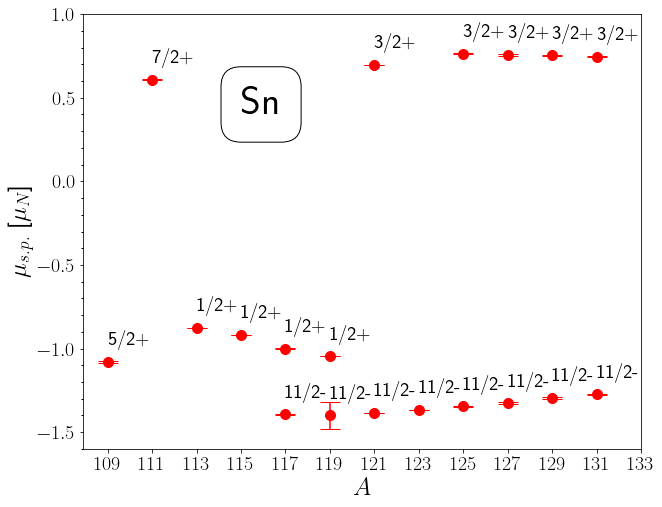

In [20]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(datamll[3])):
    try: 
        if len(datamll[3][i]) == 2:
            lower_error.append(datamll[3][i][1])
            upper_error.append(datamll[3][i][0])
    except: 
        lower_error.append(datamll[3][i])
        upper_error.append(datamll[3][i])
# =================================================================================        

# Odd Z
#datamll_Z_Z = [] 
#datamll_A_Z = [] 
datamll_mu_Z = [] 
datamll_lower_Z = [] 
datamll_upper_Z = [] 
#datamll_E_Z = [] 
datamll_jp_Z = []

# Odd N
#datamll_Z_N = [] 
datamll_A_N = [] 
datamll_mu_N = [] 
datamll_lower_N = [] 
datamll_upper_N = [] 
#datamll_E_N = [] 
datamll_jp_N = []

for i in range(len(datamll[0])):
    
    if (datamll[0][i]==50):
        # Append in the odd N array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            
        datamll_mu_N.append(datamll[2][i])
        datamll_A_N.append(datamll[1][i])
        datamll_lower_N.append(lower_error[i])
        datamll_upper_N.append(upper_error[i])
        datamll_jp_N.append(datamll[5][i])
        
    # Odd Odd
    if (datamll[0][i]%2==1 and datamll[1][i]%2==0):
        print(datamll[0][i], datamll[1][i], datamll[2][i], datamll[3][i])

        
# =================================================================================        
    
# # Odd Z
# #datamll_Z_Z = [] 
# #datamll_A_Z = [] 
# datamsl_mu_Z = [] 
# datamsl_lower_Z = [] 
# datamsl_upper_Z = [] 
# #datamll_E_Z = [] 
# datamsl_jp_Z = []

# # Odd N
# #datamll_Z_N = [] 
# datamsl_A_N = [] 
# datamsl_mu_N = [] 
# datamsl_lower_N = [] 
# datamsl_upper_N = [] 
# #datamll_E_N = [] 
# datamsl_jp_N = []

# for i in range(len(datamsl[0])):
    
#     if (datamsl[0][i]==50):
#         # Append in the odd N array
#         if "(" in datamsl[5][i]:
#             jjpp = datamsl[5][i].replace("(","")
#             jjpp = jjpp.replace(")","")
            
#             if "/" not in jjpp:
#                 continue
                
#             jjpp = float(jjpp.split("/")[0])/2
#         else:
#             jjpp = float(datamsl[5][i].split("/")[0])/2
            
#         datamsl_mu_N.append(datamll[2][i])
#         datamsl_A_N.append(datamll[1][i])
#         datamsl_lower_N.append(lower_error[i])
#         datamsl_upper_N.append(upper_error[i])
#         datamsl_jp_N.append(datamll[5][i])
        
        
asymmetric_error_N = np.array(list(zip(datamll_lower_N, datamll_upper_N))).T
plt.errorbar(datamll_A_N, datamll_mu_N, yerr=asymmetric_error_N, fmt='o', color = "red", markersize=10, capsize=10, label=r"Odd-$N$") 

for i in range(len(datamll_A_N)):
    plt.text(datamll_A_N[i], datamll_mu_N[i]+0.1, datamll_jp_N[i], fontsize=20)

    
    
# asymmetric_error_N = np.array(list(zip(datamsl_lower_N, datamsl_upper_N))).T
# plt.errorbar(datamsl_A_N, datamsl_mu_N, yerr=asymmetric_error_N, fmt='o', color = "red", markersize=10, capsize=10, label=r"Odd-$N$") 

# for i in range(len(datamsl_A_N)):
#     plt.text(datamsl_A_N[i], datamsl_mu_N[i]+0.1, datamsl_jp_N[i], fontsize=20)
    

#plt.yticks(np.arange(int(min(datamll[2]))-1, int(max(datamll[2]))+2, 1), size=20)
#plt.xlim(0.2,6.8)
plt.ylim(-1.6, 1)

plt.xlabel("Z", size=30)
plt.ylabel(r"$\mu$ [$\mu_N$]", size=30)

#####################################################################################################
# Schmidt lines
#####################################################################################################

#plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=20)
plt.xticks(np.arange(109,135,2), fontsize=20)
plt.yticks(fontsize=20)
plt.text(115,0.4,"Sn", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=40 )#, edge="black")

# plt.plot(jj, mupp ,"-", c="red", markersize=10, zorder=30)# $j = l+1/2$"
# plt.plot(jj, mump ,"-", c="red", markersize=10, zorder=30)# $j = l-1/2$"

# plt.plot(jj, mupn ,"-", c="blue", markersize=10, zorder=30)# $j = l+1/2$"
# plt.plot(jj, mumn ,"-", c="blue", markersize=10, zorder=30)# $j = l-1/2$"

plt.xlabel("$A$", fontsize=25)
plt.ylabel(r"$\mu_{s.p.}$ [$\mu_N$]", fontsize=25)
#plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)

# plt.text(1.9, 5.5 , r"$j = l+1/2$",fontsize=20, color="red")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
# plt.text(5.4, 3.1 , r"$j = l-1/2$",fontsize=20, color="red")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
# plt.text(5., 1.9 , r"$j = l-1/2$",fontsize=20, color="blue")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
# plt.text(5., -2.33 , r"$j = l+1/2$",fontsize=20, color="blue")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")

#plt.hlines(0, 0.5, 6.5, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)
plt.tick_params(axis='y', which='minor', length=2, width=1)

#plt.savefig("MExp.png", dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

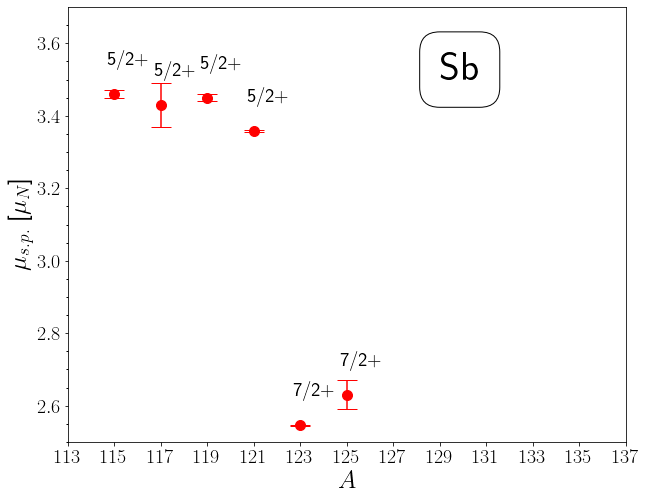

In [21]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(datamll[3])):
    try: 
        if len(datamll[3][i]) == 2:
            lower_error.append(datamll[3][i][1])
            upper_error.append(datamll[3][i][0])
    except: 
        lower_error.append(datamll[3][i])
        upper_error.append(datamll[3][i])
# =================================================================================        

# Odd Z
#datamll_Z_Z = [] 
#datamll_A_Z = [] 
datamll_mu_Z = [] 
datamll_lower_Z = [] 
datamll_upper_Z = [] 
#datamll_E_Z = [] 
datamll_jp_Z = []

# Odd N
#datamll_Z_N = [] 
datamll_A_N = [] 
datamll_mu_N = [] 
datamll_lower_N = [] 
datamll_upper_N = [] 
#datamll_E_N = [] 
datamll_jp_N = []

for i in range(len(datamll[0])):
    
    if (datamll[0][i]==51):
        # Append in the odd N array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            
        datamll_mu_N.append(datamll[2][i])
        datamll_A_N.append(datamll[1][i])
        datamll_lower_N.append(lower_error[i])
        datamll_upper_N.append(upper_error[i])
        datamll_jp_N.append(datamll[5][i])
        
    # Odd Odd
    if (datamll[0][i]%2==1 and datamll[1][i]%2==0):
        print(datamll[0][i], datamll[1][i], datamll[2][i], datamll[3][i])
        
asymmetric_error_N = np.array(list(zip(datamll_lower_N, datamll_upper_N))).T
plt.errorbar(datamll_A_N, datamll_mu_N, yerr=asymmetric_error_N, fmt='o', color = "red", markersize=10, capsize=10, label=r"Odd-$N$") 

for i in range(len(datamll_A_N)):
    plt.text(datamll_A_N[i]-0.3, datamll_mu_N[i]+0.08, datamll_jp_N[i], fontsize=20)

#plt.yticks(np.arange(int(min(datamll[2]))-1, int(max(datamll[2]))+2, 1), size=20)
#plt.xlim(0.2,6.8)
plt.ylim(2.5,3.7)

plt.xlabel("Z", size=30)
plt.ylabel(r"$\mu$ [$\mu_N$]", size=30)

#####################################################################################################
# Schmidt lines
#####################################################################################################

#plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=20)
plt.xticks(np.arange(113,139,2), fontsize=20)
plt.yticks(fontsize=20)
plt.text(129,3.5,"Sb", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=40 )#, edge="black")

# plt.plot(jj, mupp ,"-", c="red", markersize=10, zorder=30)# $j = l+1/2$"
# plt.plot(jj, mump ,"-", c="red", markersize=10, zorder=30)# $j = l-1/2$"

# plt.plot(jj, mupn ,"-", c="blue", markersize=10, zorder=30)# $j = l+1/2$"
# plt.plot(jj, mumn ,"-", c="blue", markersize=10, zorder=30)# $j = l-1/2$"

plt.xlabel("$A$", fontsize=25)
plt.ylabel(r"$\mu_{s.p.}$ [$\mu_N$]", fontsize=25)
#plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)

# plt.text(1.9, 5.5 , r"$j = l+1/2$",fontsize=20, color="red")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
# plt.text(5.4, 3.1 , r"$j = l-1/2$",fontsize=20, color="red")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
# plt.text(5., 1.9 , r"$j = l-1/2$",fontsize=20, color="blue")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
# plt.text(5., -2.33 , r"$j = l+1/2$",fontsize=20, color="blue")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")

#plt.hlines(0, 0.5, 6.5, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)
plt.tick_params(axis='y', which='minor', length=2, width=1)

#plt.savefig("MExp.png", dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

In [22]:
M_LL[M_LL["Z"]=="51"]

,Z,Sym,A,Ex,T1/2,Jπ,m(nm),Method,NSR_Keynumber,Journal_Reference
517,51,Sb,114,0,3.49m,3+,1.72(8),NO/S,1993Bo46,HFI78133(93)
518,51,Sb,115,0,32.1m,5/2+,+3.46(1),AB,1968Ja05,PR17565(68)
519,51,Sb,116,0,15.8m,3+,2.715(9),NMR/ON,1986Gr16,PL177B159(86)
520,51,Sb,116,383,60.3m,8-,2.59(22),NO/S,1993Bo46,HFI78133(93)
521,51,Sb,117,0,2.80h,5/2+,+3.43(6),AB,1974Ek01,NPA226219(74)
522,51,Sb,118,0,3.6m,1+,(+)2.46(7),AB,1968Ja05,PR17565(68)
523,51,Sb,118,250,5.0h,8-,2.32(4),NMR/ON,1974Ca06,NPA2211(74)
524,51,Sb,119,0,38.2h,5/2+,+3.45(1),AB,1968Ja05,PR17565(68)
525,51,Sb,120,0,15.9m,1+,2.3(2),AB,1968Ja05,PR17565(68)
526,51,Sb,120,0+x,5.76d,8-,2.34(3),NMR/ON,1974Ca06,NPA2211(74)


# Quadrupole moments

In [23]:
Q_ = Q.copy()
Q_["A"] = pd.to_numeric(Q_["A"], downcast='integer', errors='coerce')
dataq = extract_q(Q_, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

None of the available formats:


Z                                               48
Sym                                             Cd
A                                              109
E(level)                                       463
T_1/2                                       10.9µs
I                                            11/2-
Q(b)                                    [-0.92(9)]
Ref._Std.                                         
Method                                  systematic
NSR_Keynumber                                  not
Journal_reference    measured1978Sp09HFI4229(1978)
Name: 387, dtype: object

None of the available formats:


Z                                            50
Sym                                          Sn
A                                           116
E(level)                                   3547
T_1/2                                     833ns
I                                           10+
Q(b)                               [(-)0.41(4)]
Ref._Std.                                     B
Method                                      not
NSR_Keynumber                          measured
Journal_reference    1975Di02 PL B55 293 (1975)
Name: 457, dtype: object

None of the available formats:


Z                                                    84
Sym                                                  Po
A                                                   210
E(level)                                           1557
T_1/2                                              99ns
I                                                    8+
Q(b)                                         [-0.55(2)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1991Be03NPA522483(1991)
Name: 1041, dtype: object

None of the available formats:


Z                                                    85
Sym                                                  At
A                                                   211
E(level)                                           1417
T_1/2                                            35.1ns
I                                                 21/2-
Q(b)                                     [(-)0.524(10)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1995Ba66NPA591104(1996)
Name: 1073, dtype: object

None of the available formats:


Z                                                    86
Sym                                                  Rn
A                                                   212
E(level)                                           1694
T_1/2                                            0.91ms
I                                                    8+
Q(b)                                         [-0.18(2)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1985Da13NPA441501(1985)
Name: 1088, dtype: object

None of the available formats:


Z                                                 87
Sym                                               Fr
A                                                213
E(level)                                        2538
T_1/2                                          238ns
I                                              29/2+
Q(b)                                      [-0.70(7)]
Ref._Std.                                           
Method                                    calculated
NSR_Keynumber                                    not
Journal_reference    measured1990By03NPA516145(1990)
Name: 1112, dtype: object

None of the available formats:


Z                                                   91
Sym                                                 Pa
A                                                  231
E(level)                                             0
T_1/2                                         3.3x104y
I                                                 3/2-
Q(b)                                        [-1.72(5)]
Ref._Std.                                             
Method                                            from
NSR_Keynumber                                    B(E2)
Journal_reference    notmeasured1978Fr28PLA69225(1975)
Name: 1135, dtype: object

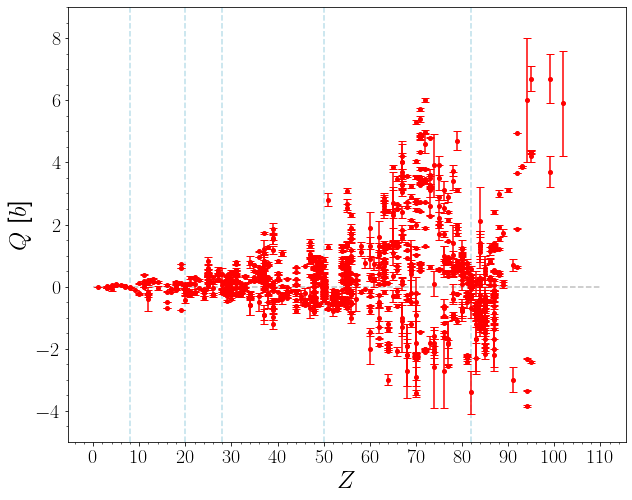

In [24]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "red" ,markersize=4, capsize=4, label="$Q$ vs $Z$", zorder=50) 
#plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "blue" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(20, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(28, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(50, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(82, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
#plt.vlines(126, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,130,10), fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$Z$", fontsize=25)
plt.ylabel(r"$Q$ [$b$]", size=25)

plt.hlines(0, 0, 110, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)

#plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp4.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp4.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp4.pdf", dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

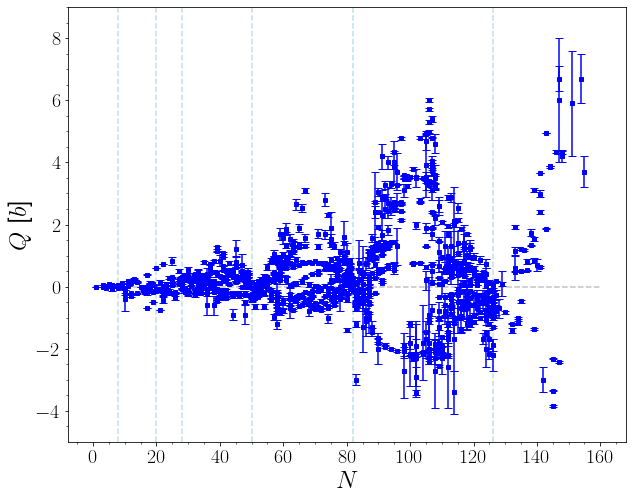

In [25]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
#plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "red" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "blue" ,markersize=4, capsize=4, label="$Q$ vs $N$", zorder=50) 
plt.vlines(8, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(20, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(28, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(50, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(82, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(126, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$N$", fontsize=25)
plt.ylabel(r"$Q$ [$b$]", size=25)

plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)

#plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp3.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp3.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp3.pdf", dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

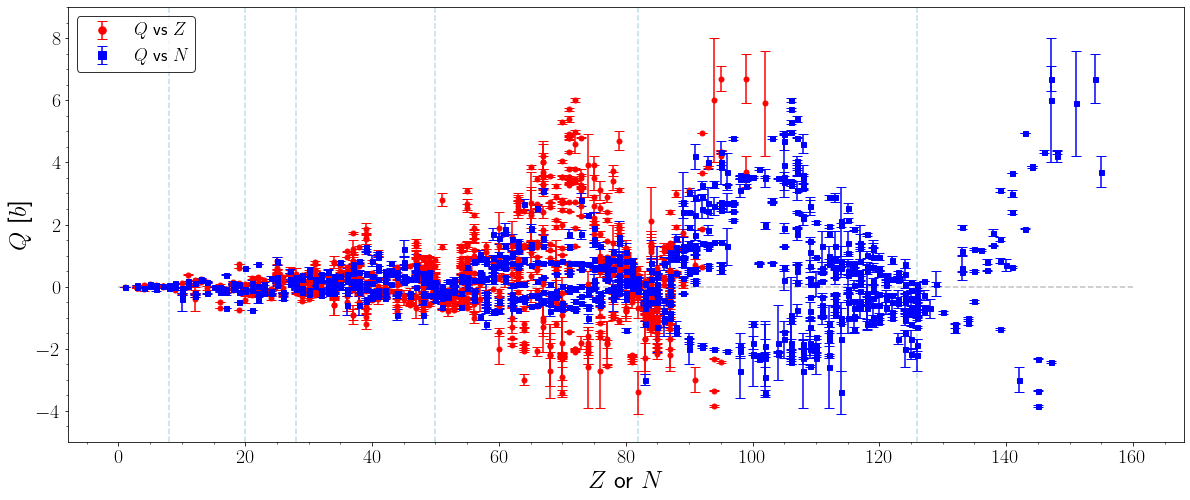

In [26]:
plt.figure(figsize=((20,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "red" ,markersize=5, capsize=5, label="$Q$ vs $Z$", zorder=50) 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "blue" ,markersize=5, capsize=5, label="$Q$ vs $N$", zorder=50) 
plt.vlines(8, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(20, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(28, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(50, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(82, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(126, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$Z$ or $N$", fontsize=25)
plt.ylabel(r"$Q$ [$b$]", size=25)

plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)

plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp2.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp2.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp2.pdf", dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

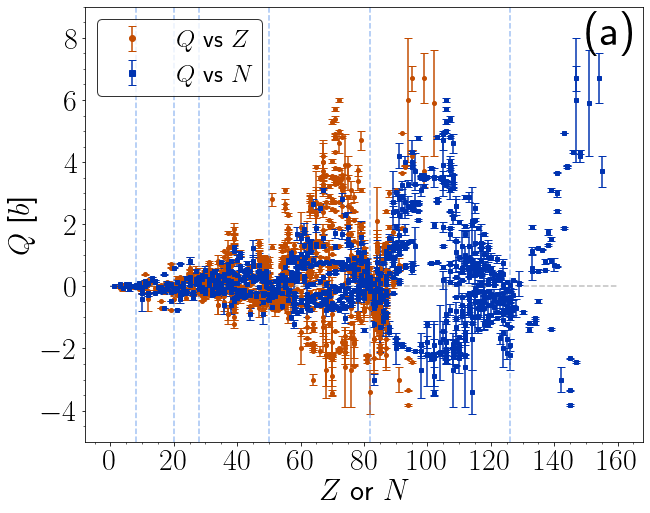

In [32]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q$ [$b$]", size=30)
plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)

plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb.pdf", facecolor='white', bbox_inches='tight')

plt.show()

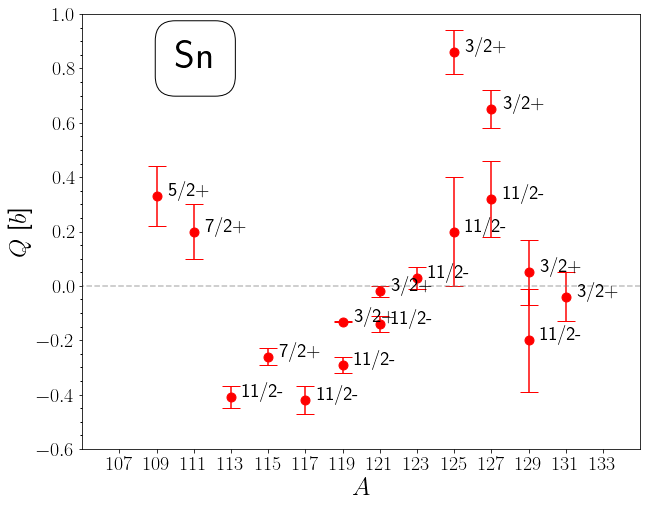

In [28]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    if dataq[0][i] == 50 and dataq[1][i]%2 == 1:
        dataqq.append(dataq[2][i])
        dataq_A.append(dataq[1][i])
        dataq_Z.append(dataq[0][i])
        dataq_N.append(dataq[1][i] - dataq[0][i])
        dataq_jp.append(dataq[5][i])

        dataq_lower.append(lower_error[i])
        dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
#plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "red" ,markersize=5, capsize=5, label="$Q$ vs $Z$") 
plt.errorbar(dataq_A, dataqq, yerr=asymmetric_error, fmt='o', color = "red" ,markersize=9, capsize=9, label="$Q$ vs $N$") 
for i in range(len(dataq_N)):
    plt.text(dataq_A[i]+0.6, dataqq[i], dataq_jp[i], fontsize=20)
# plt.vlines(8, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
# plt.vlines(20, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
# plt.vlines(28, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(50, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
# plt.vlines(82, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
# plt.vlines(126, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)


plt.xticks(np.arange(107,135, 2), fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$A$", fontsize=25)
plt.ylabel(r"$Q$ [$b$]", size=25)

plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.xlim(105, 135)
plt.ylim(-0.6, 1)

plt.text(110,0.8,"Sn", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=40 )#, edge="black")

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)
plt.tick_params(axis='y', which='minor', length=2, width=1)

#plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)

plt.show()

In [29]:
Q[Q["Z"]=="50"]

,Z,Sym,A,E(level),T_1/2,I,Q(b),Ref._Std.,Method,NSR_Keynumber,Journal_reference
445,50,Sn,109,0,18.0m,5/2+,+0.33(11),A,ABLFS,1987Eb01,ZP A326 121 (1987)
446,50,Sn,110,2478,5.6ns,6+,0.30(4),C,TDPAD,1989Vo17,IAN Ser Fiz 53 2188 (1989)
447,50,Sn,111,0,35.3m,7/2+,+0.20(10),A,ABLFS,1987Eb01,ZP A326 121 (1987)
448,50,Sn,112,1257,0.38ps,2+,+0.04(9),,CER,2015Al24,PRC92041303(R)(2015)
449,50,Sn,112,2549,13.7ns,6+,(-)0.25(5),B,TDPAD,1975Vi03,NP A243 29 (1973)
450,50,Sn,113,738,86ns,11/2-,(-)0.41(4),B,TDPAD,1975Di02,PL B55 293 (1975)
451,50,Sn,114,1300,0.42ps,2+,+0.09(8),,CER,2015Al24,PRC92041303(R)(2015)
452,50,Sn,114,3087,733ns,7-,(-)0.32(3),B,TDPAD,1975Di02,PL B55 293 (1975)
453,50,Sn,115,613,3.26ps,7/2+,(-)0.26(3),C,TDPAD,1976Be59,HFI 2 326 (1976)
454,50,Sn,115,714,159µs,11/2-,0.38(6),,QIR,1975Ri03,PhysScr11228(1975)


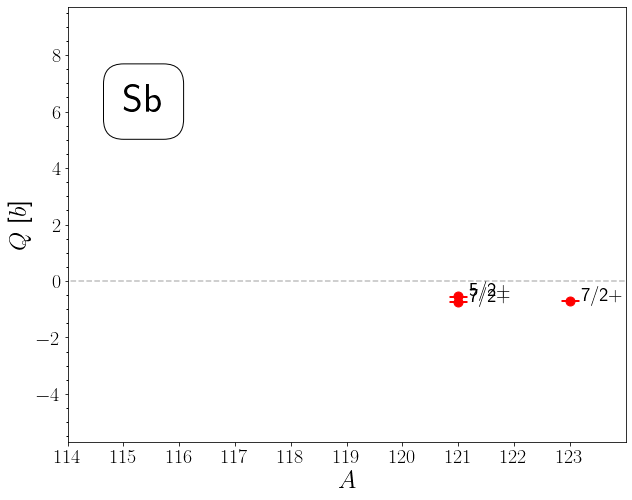

In [30]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    if dataq[0][i] == 51 and dataq[1][i]%2 == 1:
        dataqq.append(dataq[2][i])
        dataq_A.append(dataq[1][i])
        dataq_Z.append(dataq[0][i])
        dataq_N.append(dataq[1][i] - dataq[0][i])
        dataq_jp.append(dataq[5][i])

        dataq_lower.append(lower_error[i])
        dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
#plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "red" ,markersize=5, capsize=5, label="$Q$ vs $Z$") 
plt.errorbar(dataq_A, dataqq, yerr=asymmetric_error, fmt='o', color = "red" ,markersize=9, capsize=9, label="$Q$ vs $N$") 
for i in range(len(dataq_N)):
    plt.text(dataq_A[i]+0.2, dataqq[i], dataq_jp[i], fontsize=20)
# plt.vlines(8, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
# plt.vlines(20, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
# plt.vlines(28, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(50, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
# plt.vlines(82, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
# plt.vlines(126, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)


plt.xticks(np.arange(114,124, 1), fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$A$", fontsize=25)
plt.ylabel(r"$Q$ [$b$]", size=25)

plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.xlim(114, 124)
#plt.ylim(-0.6, 1)

plt.text(115,6,"Sb", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=40 )#, edge="black")

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)
plt.tick_params(axis='y', which='minor', length=2, width=1)

#plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)

plt.show()

In [31]:
Q[Q["Z"]=="51"]

,Z,Sym,A,E(level),T_1/2,I,Q(b),Ref._Std.,Method,NSR_Keynumber,Journal_reference
483,51,Sb,112,796,536ns,8-,1.06(2),[121Sb],TDPAD,1982Ma29,PR C26 493 (1982)
484,51,Sb,114,496,219µs,8-,1.02(16),[121Sb],"QIR,R",1982Ma29,PR C26 493 (1982)
485,51,Sb,115,2796,159ns,19/2-,0.79(4),[121Sb],TDPAD,1983Se04,ZP A309 349 (1983)
486,51,Sb,116,1159,10.6ns,7+,2.5(6),[121Sb],TDPAD,1992Io01,ZP A343 21 (1992)
487,51,Sb,117,0,2.80h,5/2+,0.2(12),[121Sb],AB,1974Ek01,NP A226 219 (1974)
488,51,Sb,117,3131,355µs,(25/2)+,1.14(5),[121Sb],"QIR,R",1982Ma29,PR C26 493 (1982)
489,51,Sb,117,3231,290ns,23/2-,3.7(4),[121Sb],TDPAD,1988Io01,PL B 200 259 (1988)
490,51,Sb,118,51,20.6µs,(3)+,0.9(2),[121Sb],TDPAD,1982Ma29,PR C26 493 (1982)
491,51,Sb,118,270,13.4ns,3-,0.39(8),[121Sb],TDPAD,1985Di07,ZP A320 613 (1985)
492,51,Sb,118,965,22.6ns,7+,2.6(5),[121Sb],TDPAD,1988Io01,PL B 200 259 (1988)


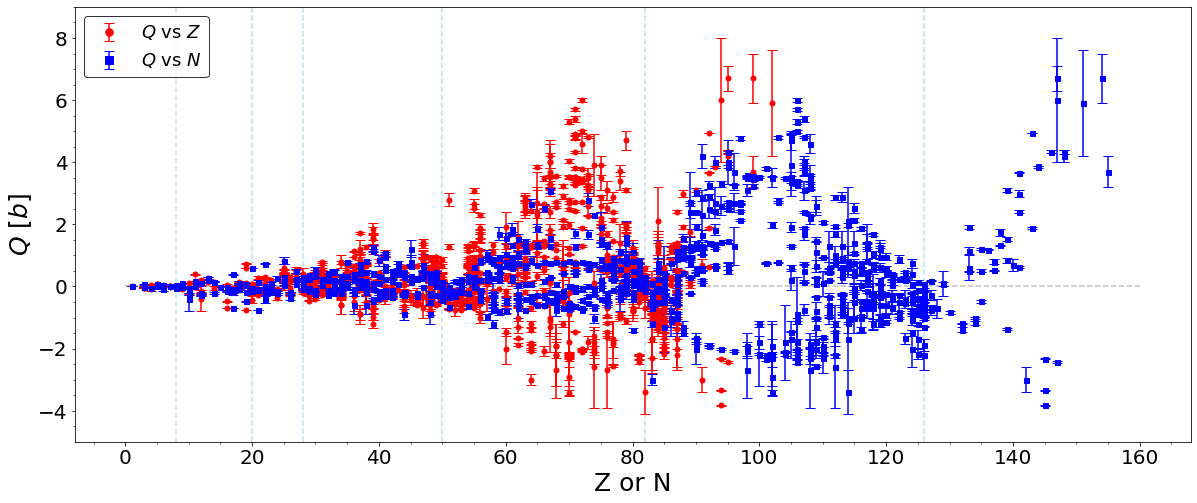

In [33]:
plt.figure(figsize=((20,8)))
plt.rcParams["text.usetex"] = False

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "red" ,markersize=5, capsize=5, label="$Q$ vs $Z$", zorder=50) 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "blue" ,markersize=5, capsize=5, label="$Q$ vs $N$", zorder=50) 
plt.vlines(8, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(20, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(28, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(50, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(82, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)
plt.vlines(126, -5, 9, colors='lightblue', linestyles='--', alpha=0.8)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("Z or N", fontsize=25)
plt.ylabel(r"$Q$ [$b$]", size=25)

plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)

plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp2lq.svg", facecolor='white', bbox_inches='tight')
plt.savefig("QExp2lq.png", facecolor='white', bbox_inches='tight')
plt.savefig("QExp2lq.pdf", facecolor='white', bbox_inches='tight')

plt.show()

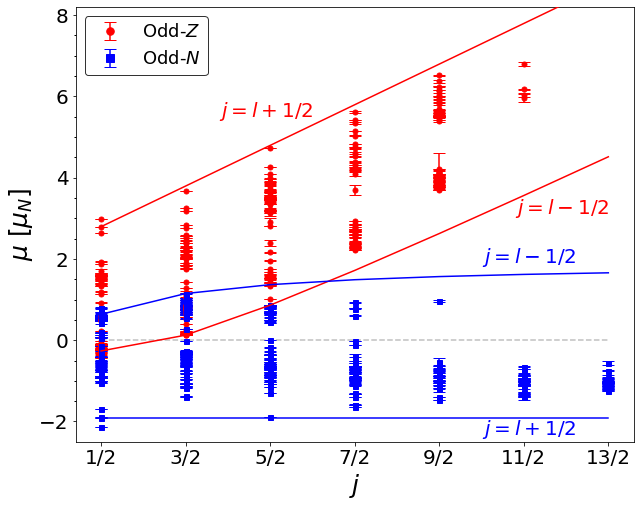

In [34]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = False

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(datamll[3])):
    try: 
        if len(datamll[3][i]) == 2:
            lower_error.append(datamll[3][i][1])
            upper_error.append(datamll[3][i][0])
    except: 
        lower_error.append(datamll[3][i])
        upper_error.append(datamll[3][i])
# =================================================================================        

# Odd Z
#datamll_Z_Z = [] 
#datamll_A_Z = [] 
datamll_mu_Z = [] 
datamll_lower_Z = [] 
datamll_upper_Z = [] 
#datamll_E_Z = [] 
datamll_jp_Z = []

# Odd N
#datamll_Z_N = [] 
#datamll_A_N = [] 
datamll_mu_N = [] 
datamll_lower_N = [] 
datamll_upper_N = [] 
#datamll_E_N = [] 
datamll_jp_N = []

for i in range(len(datamll[0])):
        
    if (datamll[0][i]%2==1 and datamll[1][i]%2==1):
        # Append in the odd Z array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            
        datamll_mu_Z.append(datamll[2][i])
        datamll_lower_Z.append(lower_error[i])
        datamll_upper_Z.append(upper_error[i])
        datamll_jp_Z.append(jjpp)
    
    if (datamll[0][i]%2==0 and datamll[1][i]%2==1):
        # Append in the odd N array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            

            
        datamll_mu_N.append(datamll[2][i])
        datamll_lower_N.append(lower_error[i])
        datamll_upper_N.append(upper_error[i])
        datamll_jp_N.append(jjpp)
        
    # Odd Odd
    if (datamll[0][i]%2==1 and datamll[1][i]%2==0):
        print(datamll[0][i], datamll[1][i], datamll[2][i], datamll[3][i])
        
    
asymmetric_error_Z = np.array(list(zip(datamll_lower_Z, datamll_upper_Z))).T
plt.errorbar(datamll_jp_Z, datamll_mu_Z, yerr=asymmetric_error_Z, fmt='o', color = "red" ,markersize=5, capsize=6, label=r"Odd-$Z$") 
asymmetric_error_N = np.array(list(zip(datamll_lower_N, datamll_upper_N))).T
plt.errorbar(datamll_jp_N, datamll_mu_N, yerr=asymmetric_error_N, fmt='s', color = "blue", markersize=5, capsize=6, label=r"Odd-$N$") 

#plt.yticks(np.arange(int(min(datamll[2]))-1, int(max(datamll[2]))+2, 1), size=20)
plt.xlim(0.2,6.8)
plt.ylim(-2.5,8.2)

plt.xlabel("Z", size=30)
plt.ylabel(r"$\mu$ [$\mu_N$]", size=30)

#####################################################################################################
# Schmidt lines
#####################################################################################################

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=20)
plt.yticks(fontsize=20)

plt.plot(jj, mupp ,"-", c="red", markersize=10, zorder=30)# $j = l+1/2$"
plt.plot(jj, mump ,"-", c="red", markersize=10, zorder=30)# $j = l-1/2$"

plt.plot(jj, mupn ,"-", c="blue", markersize=10, zorder=30)# $j = l+1/2$"
plt.plot(jj, mumn ,"-", c="blue", markersize=10, zorder=30)# $j = l-1/2$"

plt.xlabel("$j$", fontsize=25)
plt.ylabel(r"$\mu$ [$\mu_N$]", fontsize=25)
plt.legend(fontsize=18, edgecolor="black", loc="upper left", markerscale=1.5)

plt.text(1.9, 5.5 , r"$j = l+1/2$",fontsize=20, color="red")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
plt.text(5.4, 3.1 , r"$j = l-1/2$",fontsize=20, color="red")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
plt.text(5., 1.9 , r"$j = l-1/2$",fontsize=20, color="blue")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
plt.text(5., -2.33 , r"$j = l+1/2$",fontsize=20, color="blue")#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))#, edge="black")
#plt.text(6.45, 7.3, "b", fontsize=45, weight='bold' )

plt.hlines(0, 0.5, 6.5, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)
plt.tick_params(axis='y', which='minor', length=2, width=1)

plt.savefig("Msp+Exp_ll_v2lq.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("Msp+Exp_ll_v2lq.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("Msp+Exp_ll_v2lq.pdf", dpi=300, facecolor='white', bbox_inches='tight')

plt.savefig("MExplq.pdf", dpi=300, facecolor='white', bbox_inches='tight')

plt.show()

# Ground states intrinsic quadrupole deformation

In [285]:
# Eq. 5.45 Takigawa. 5.10 Krane
def r2(A):
    return 3/5*1.2**2*A**(2/3)/100   # barns 

    
def Q_sp(j,A):
    return -(2*j-1)/(2*(j+1))*r2(A)

def Q_0_sp(j,A):
    return -(2*j+3)/(2*j)*r2(A)/100

def N(Z):
    return 0.910771*Z + 0.032701*(Z**(5/3))

In [286]:
Q_ = Q.copy()
Q_["A"] = pd.to_numeric(Q_["A"], downcast='integer', errors='coerce')
Q_= Q_[Q_["E(level)"]=="0"]
Q_ = Q_[~Q_["I"].str.contains("or")]
Q_ = Q_[~Q_["I"].str.contains(",")]

dataq = extract_q(Q_, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

None of the available formats:


Z                                                   91
Sym                                                 Pa
A                                                  231
E(level)                                             0
T_1/2                                         3.3x104y
I                                                 3/2-
Q(b)                                        [-1.72(5)]
Ref._Std.                                             
Method                                            from
NSR_Keynumber                                    B(E2)
Journal_reference    notmeasured1978Fr28PLA69225(1975)
Name: 1135, dtype: object

In [287]:
Q_

,Z,Sym,A,E(level),T_1/2,I,Q(b),Ref._Std.,Method,NSR_Keynumber,Journal_reference
0,1,H,2,0,stable,1+,+0.0028578(3),,"MB,R",1958Qu02,PR1121929(19)
1,3,Li,6,0,stable,1+,-0.000806(6),[Li7],MB,2005Bo45,PR C72 044309 (2005)
2,3,Li,7,0,stable,3/2-,-0.0400(3),,MB,2008Py02,MolPhys1061965(2008)
3,3,Li,8,0,840ms,2+,+0.0314(2),[Li7],β-NMR,2005Bo45,PR C72 044309 (2005)
4,3,Li,9,0,178ms,3/2-,-0.0304(2),[Li7],β-NMR,2011Av08,J Phys G 38 075102 (2011)
5,3,Li,11,0,8.75ms,3/2-,(-)0.0333(5),[Li7],β-NMR,2008Ne11,PRL 101 132502 (2008)
6,4,Be,9,0,stable,3/2-,+0.0529(4),,AB,1991Su05,CPL17791(1991)
8,5,B,8,0,0.77s,2+,+0.0643(14),[11B],β-NQR,2006Su13,PR C74 024327 (2006)
9,5,B,10,0,stable,3+,+0.0846(2),[11B],AB,2008Py02/1970Ne21,Mol Phys 106 1965 (2008)/PR A2 1208 (1970)
10,5,B,11,0,stable,3/2-,+0.04059(10),,AB,2008Py02,MolPhys1061965(2008)


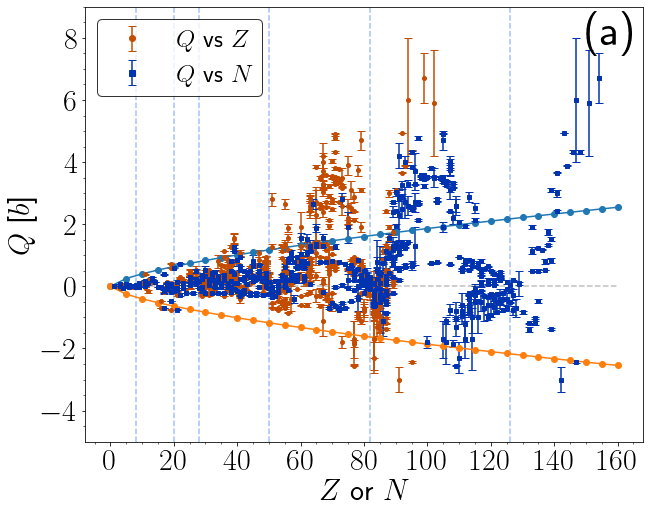

In [288]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q$ [$b$]", size=30)
plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)



# # Adding sp-lines
# plt.plot(np.arange(0,165,5), Q_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_sp(7/2,np.arange(0,165,5)), "o-")



# Adding sp-lines
plt.plot(np.arange(0,165,5), 3/5*0.1*1.2**2*np.arange(0,165,5)**(2/3), "o-")
plt.plot(np.arange(0,165,5), -3/5*0.1*1.2**2*np.arange(0,165,5)**(2/3), "o-")





plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-gs.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-gs.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-gs.pdf", facecolor='white', bbox_inches='tight')

plt.show()

### Conversion of $Q$ to $Q_0$

In [232]:
# COnverting the spin values in floats
for j in range(len(dataq[5])):
    
    dataq[5][j]=dataq[5][j].replace(")","").replace("+","").replace("-","").replace("(","").replace("[","").replace("]","")
    
    if "/" in dataq[5][j]:
        num = int(dataq[5][j].split("/")[0])
        den = int(dataq[5][j].split("/")[1])
        dataq[5][j]=float(num/den)
        
    else:
        dataq[5][j] = int(dataq[5][j])  

In [233]:
# Converting Q into Q_o

for j in range(len(dataq[2])):

    dataq[2][j] = (dataq[5][j]+1)*(2*dataq[5][j]+3)/(dataq[5][j]*(2*dataq[5][j]-1))*dataq[2][j]



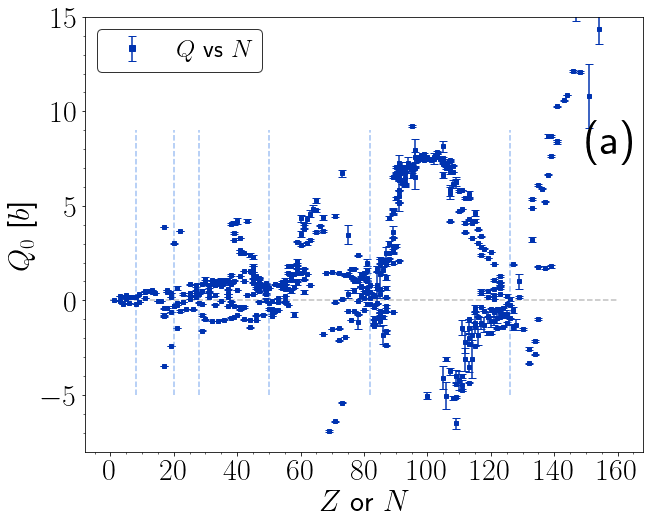

In [234]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
#plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-8, 15)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q_0$ [$b$]", size=30)
plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)



# # Adding sp-lines
# plt.plot(np.arange(0,165,5), Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(9/2,np.arange(0,165,5)), "o-")

# plt.plot(np.arange(0,165,5), -1*Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(9/2,np.arange(0,165,5)), "o-")










plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-sp.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-sp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-sp.pdf", facecolor='white', bbox_inches='tight')

plt.show()

In [235]:
dataq_df = pd.DataFrame(np.array(dataq).T, columns=["Z", "A", "q", "un", "E", "jp"])
dataq_df

,Z,A,q,un,E,jp
0,1.0,2.0,0.028578,3.000000e-07,0.0,1.0
1,3.0,6.0,-0.008060,6.000000e-06,0.0,1.0
2,3.0,7.0,-0.200000,3.000000e-04,0.0,1.5
3,3.0,8.0,0.109900,2.000000e-04,0.0,2.0
4,3.0,9.0,-0.152000,2.000000e-04,0.0,1.5
5,3.0,11.0,-0.166500,5.000000e-04,0.0,1.5
6,4.0,9.0,0.264500,4.000000e-04,0.0,1.5
7,5.0,8.0,0.225050,1.400000e-03,0.0,2.0
8,5.0,10.0,0.203040,2.000000e-04,0.0,3.0
9,5.0,11.0,0.202950,1.000000e-04,0.0,1.5


In [295]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sympy
from operator import itemgetter

# Constants
hbar = 6.582119569*10**(-22)           # MeV*s
c = 2.99792458*10**(8)*10**(15)        # fm/s
m_p = 938.27/c**2                      # MeV*s²/fm²
m_n = 939.57/c**2                      # MeV*s²/fm²

def hbaromega(A):                          # Parameters: A mass number of nucleus
    return 45*A**(-1/3) - 25*A**(-2/3) 

def b(m,A):                                # Parameters: m mass of nucleon, A mass number of nucleus
    return hbar/np.sqrt(m*hbaromega(A))


# Harmonic oscillator radial wavefunction
def psiHO(r, n, l, m, A):                 # Parameters: r coordinate, n radial quantum number
                                          #             l orbital angular momentum,
                                          #             m mass of nucleon, A mass number of nucleus
    bv = b(m,A)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv**3*scp.special.gamma(n+l+3/2)))
    return norm*(r/bv)**l*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)

# Function to compute matrix elements <r^2>
def Integrand(r,n1,n2,l,j,m,A,part):           # Parameters: r coordinate, n1, n2 radial quantum numbers, 
                                                 #             l orbital angular momentum, N number of neutrons,
                                                 #             Z number of protons, part = 0 for proton and 
                                                 #             1 for neutron, j total angular momentum
    f1 = psiHO(r, n1, l, m, A)
    
    return r**4*f1*f1

def MatrixElement(n1,n2,l,j,m,A,part):
    
    return scp.integrate.quad(Integrand, 0, 500, args=(n1,n2,l,j,m,A,part))[0]   # Integral up to 200fm

In [296]:
Shells = [[[0,0,1/2, 2],
[0,1,3/2, 6],       #Shell N=8
[0,1,1/2, 8]],
[[0,2,5/2, 14],
 [1,0,1/2, 16],
 [0,2,3/2, 20]],      #Shell N=20  
[[0,3,7/2, 28]],     #Shell N=28
[[1,1,3/2, 32], 
 [0,3,5/2, 38],      #Shell N=50  
 [1,1,1/2, 40],
 [0,4,9/2, 50]],
[[0,4,7/2, 58], 
 [1,2,5/2, 64],      #Shell N=82  
 [1,2,3/2, 68],
 [2,0,1/2, 70],
 [0,5,11/2,82]],
[[0,5,9/2, 92], 
 [1,3,7/2, 100]]]
 
 
                #,      #Shell N=126  
#  [1,3,5/2, 106],
#  [2,1,3/2, 110],
#  [2,1,1/2, 112],
#  [0,6,13/2, 126]],
# [[1,4,9/2, 136], 
#  [2,2,5/2, 142],      #Shell N=184  
#  [0,6,11/2, 154],
#  [1,4,7/2, 162],
#  [3,0,1/2, 164],
#  [1,2,3/2, 168],
#  [0,7,15/2, 184]]]

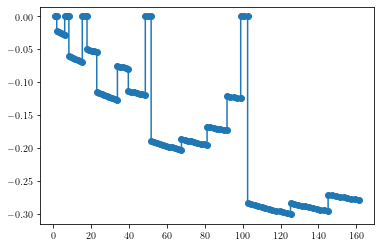

In [340]:
Q_values = []
Q0_values = []
N_values = []
N_carry = 1

for shell in Shells:
    for orbit in shell:
        
        n = orbit[0]
        l = orbit[1]
        j = orbit[2]
        N_shell = orbit[3]  # Total accumulated particles
        
        for proton in range(N_carry, N_shell+1):
            
            A = int(proton + N(proton))
            Q_sp_ = -(2*j-1)/(2*(j+1))*MatrixElement(n,n,l,j,m_n,A,0)/100   #barns
            Q0_sp_ = -(2*j+3)/(2*(j))*MatrixElement(n,n,l,j,m_n,A,0)/100   #barns

            
            Q_values.append(Q_sp_)
            Q0_values.append(Q0_sp_)
            N_values.append(N(proton))
            
            N_carry = N_shell
            
plt.plot(N_values, Q_values,"o-")


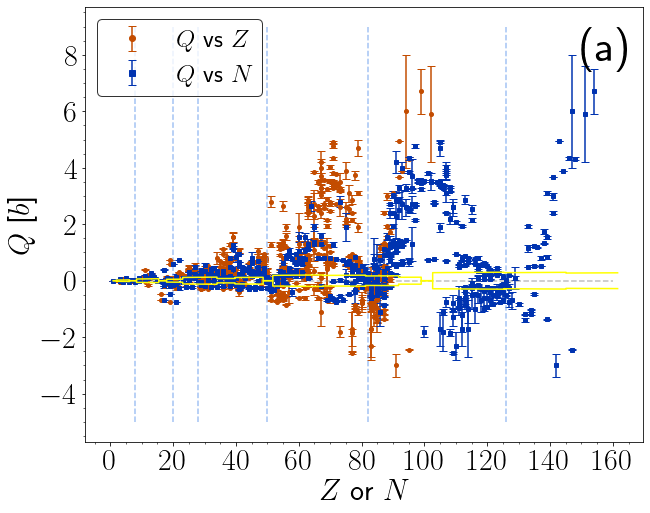

In [342]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)

#plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q$ [$b$]", size=30)
plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)

plt.plot(N_values, -1*np.array(Q_values),"-",c="yellow", zorder=30)
plt.plot(N_values, Q_values,"-",c="yellow", zorder=30)


plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-gs.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-gs.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-gs.pdf", facecolor='white', bbox_inches='tight')

plt.show()

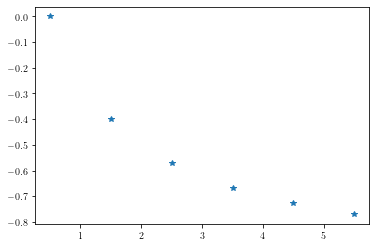

In [334]:
jj= np.arange(1/2,13/2,1)
plt.plot(jj, -(2*jj-1)/(2*(jj+1)),"*")

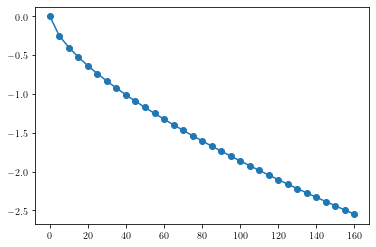

In [341]:
plt.plot(np.arange(0,165,5), -3/5*0.1*1.2**2*np.arange(0,165,5)**(2/3), "o-")


In [211]:
stable_nuclei = [
    (1, 0),    # H-1
    (2, 2),    # He-4
    (3, 4),    # Li-7
    (4, 5),    # Be-9
    (5, 6),    # B-11
    (6, 6),    # C-12
    (7, 7),    # N-14
    (8, 8),    # O-16
    (9, 10),   # F-19
    (10, 10),  # Ne-20
    (11, 12),  # Na-23
    (12, 12),  # Mg-24
    (13, 14),  # Al-27
    (14, 14),  # Si-28
    (15, 16),  # P-31
    (16, 16),  # S-32
    (17, 18),  # Cl-35
    (18, 22),  # Ar-40
    (19, 20),  # K-39
    (20, 20),  # Ca-40
    (21, 24),  # Sc-45
    (22, 26),  # Ti-48
    (23, 28),  # V-51
    (24, 28),  # Cr-52
    (25, 30),  # Mn-55
    (26, 30),  # Fe-56
    (27, 32),  # Co-59
    (28, 30),  # Ni-58
    (29, 34),  # Cu-63
    (30, 34),  # Zn-64
    (31, 39),  # Ga-69
    (32, 41),  # Ge-73
    (33, 42),  # As-75
    (34, 45),  # Se-79
    (35, 46),  # Br-81
    (36, 48),  # Kr-84
    (37, 48),  # Rb-85
    (38, 50),  # Sr-88
    (39, 50),  # Y-89
    (40, 51),  # Zr-91
    (41, 52),  # Nb-93
    (42, 54),  # Mo-98
    (43, 55),  # Tc (no stable isotope)
    (44, 57),  # Ru-101
    (45, 58),  # Rh-103
    (46, 60),  # Pd-106
    (47, 61),  # Ag-107
    (48, 64),  # Cd-112
    (49, 66),  # In-115
    (50, 70),  # Sn-120
    (51, 71),  # Sb-122
    (52, 76),  # Te-128
    (53, 74),  # I-127
    (54, 77),  # Xe-131
    (55, 78),  # Cs-133
    (56, 81),  # Ba-137
    (57, 82),  # La-139
    (58, 82),  # Ce-140
    (59, 82),  # Pr-141
    (60, 84),  # Nd-144
    (61, 84),  # Pm (no stable isotope)
    (62, 88),  # Sm-152
    (63, 89),  # Eu-153
    (64, 93),  # Gd-157
    (65, 93),  # Tb-159
    (66, 97),  # Dy-163
    (67, 98),  # Ho-165
    (68, 99),  # Er-167
    (69, 100), # Tm-169
    (70, 100), # Yb-170
    (71, 104), # Lu-175
    (72, 106), # Hf-178
    (73, 108), # Ta-181
    (74, 110), # W-184
    (75, 111), # Re-187
    (76, 114), # Os-190
    (77, 115), # Ir-193
    (78, 117), # Pt-195
    (79, 118), # Au-197
    (80, 122), # Hg-202
    (81, 124), # Tl-205
    (82, 126),  # Pb-208
    (83, 126) # Bi-209 
]